In [1]:
# general tools
import sys
from glob import glob


# data tools
import h5py
import numpy as np
from random import shuffle
from datetime import datetime, timedelta

# deep learning tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

# graph tools
import matplotlib.pyplot as plt
%matplotlib inline

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

# Global settings

In [2]:
VAR = 'TMEAN'

In [3]:
# ind_trans = 504 # now in the namelist
model_import_dir = temp_dir
# overlapped tile prediction settings
param = {}
param['gap'] = 8
param['edge'] = 32
param['size'] = 128

In [4]:
model_import_dir

'/glade/work/ksha/data/Keras/BACKUP/'

In [5]:
cmap_mae = plt.cm.plasma_r
camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

# Data

## static fields

In [6]:
# import geo. info
hdf_io = h5py.File(PRISM_dir + 'PRISM_TMAX_features_2015_2020.hdf', 'r')
land_mask = hdf_io['land_mask'][...]
etopo_4km = hdf_io['etopo_4km'][...]
etopo_regrid = hdf_io['etopo_regrid'][...]
lon_4km = hdf_io['lon_4km'][...]
lat_4km = hdf_io['lat_4km'][...]
hdf_io.close()

grid_shape = land_mask.shape

# defining prediction range
# dt list for all
N_all = 365 + 366 + 365 + 365 + 365
all_list = [datetime(2015, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# dt list for pred, 2018-2019
# N_pred = 365
# pred_list = [datetime(2019, 1, 1, 0) + timedelta(days=x) for x in range(N_pred)]

N_pred = 15
pred_list = [datetime(2019, 7, 1, 0) + timedelta(days=x) for x in range(N_pred)]

# indices
ind_pred = du.dt_match(all_list, pred_list)

In [7]:
ind_pred_sea  = du.season_ind_sep(pred_list, key_format='{}')
seasons = ['djf', 'mam', 'jja', 'son']
domains = ['train', 'trans']

## Input features

In [8]:
with h5py.File(PRISM_dir + 'PRISM_{}_features_2015_2020.hdf'.format(VAR), 'r') as hdf_io:
        PRISM_T = hdf_io['{}_4km'.format(VAR)][ind_pred, ...]
        REGRID_T = hdf_io['{}_REGRID'.format(VAR)][ind_pred, ...]

# Models

## Keras import

In [9]:
unet = {}
#unet['djf'] = keras.models.load_model(model_import_dir+'UNET-G3_{}_djf_tune.hdf'.format(VAR))
#unet['mam'] = keras.models.load_model(model_import_dir+'UNET-G3_{}_mam_tune.hdf'.format(VAR))
unet['jja'] = keras.models.load_model(model_import_dir+'UNET-G3_{}_jja_tune.hdf'.format(VAR))
#unet['son'] = keras.models.load_model(model_import_dir+'UNET-G3_{}_son_tune.hdf'.format(VAR))

In [10]:
def dummy_g_loader(model_path):
    model = keras.models.load_model(model_path, compile=False)
    W = model.get_weights()
    return W

In [11]:
activation='relu'
pool=False # stride convolution instead of maxpooling
N = [48, 96, 192, 384]
N_input = 3

In [12]:
seasons = ['jja']

In [13]:
gan = {}

for sea in seasons:   
    model_path = model_import_dir+'DEEP_G_{}_{}.hdf'.format(VAR, sea)
    W = dummy_g_loader(model_path)
    model = mu.UNET(N, (None, None, N_input), pool=pool, activation=activation)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0))
    model.set_weights(W)
    
    gan[sea] = model

In [14]:
# # GAN generator
# gan = {}
# gan['djf'] = keras.models.load_model(model_import_dir+'UNET-G3_{}_djf_tune.hdf'.format(VAR))
# gan['mam'] = keras.models.load_model(model_import_dir+'UNET-G3_{}_mam_tune.hdf'.format(VAR))
# gan['jja'] = keras.models.load_model(model_import_dir+'UNET-G3_{}_jja_tune.hdf'.format(VAR))
# gan['son'] = keras.models.load_model(model_import_dir+'UNET-G3_{}_son_tune.hdf'.format(VAR))

In [15]:
# ## GAN generator
# gan = {}
# gan['djf'] = keras.models.load_model(model_import_dir+'GAN_G_{}_djf_tune.hdf'.format(VAR))
# gan['mam'] = keras.models.load_model(model_import_dir+'GAN_G_{}_mam_tune.hdf'.format(VAR))
# gan['jja'] = keras.models.load_model(model_import_dir+'GAN_G_{}_jja_tune.hdf'.format(VAR))
# gan['son'] = keras.models.load_model(model_import_dir+'GAN_G_{}_son_tune.hdf'.format(VAR))

## Full-domain prediction

In [16]:
param

{'gap': 8, 'edge': 32, 'size': 128}

In [17]:
grid_shape = land_mask.shape

In [18]:
# allocation
RESULT_UNET = np.zeros((N_pred,)+grid_shape)
RESULT_GAN = np.zeros((N_pred,)+grid_shape)

for n, date in enumerate(pred_list):
    if n%50 == 0:
        print('progress: {}'.format(date))
    
    X = (REGRID_T[n, ...], etopo_4km, etopo_regrid)
    if date.month in [12, 1, 2]:
        temp_sea = 'djf'
    elif date.month in [3, 4, 5]:
        temp_sea = 'mam'
    elif date.month in [6, 7, 8]:
        temp_sea = 'jja'
    elif date.month in [9, 10, 11]:
        temp_sea = 'son'

    temp_unet = vu.pred_domain(X, land_mask, unet[temp_sea], param, method='norm_std')
    temp_gan = vu.pred_domain(X, land_mask, gan[temp_sea], param, method='norm_std')

    RESULT_UNET[n, ...] = temp_unet
    RESULT_GAN[n, ...] = temp_gan

progress: 2019-07-01 00:00:00


/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/verif_utils.py:105: RuntimeWarning: invalid value encountered in greater
  flag_effective = np.logical_and(~np.isnan(temp_data[..., 0]), np.abs(temp_data[..., 0])>0)


In [19]:
# ----- save to cache ----- #
save_dict = {'UNET':RESULT_UNET, 'GAN':RESULT_GAN}
np.save(temp_dir+'GAN_VERIF_2020_backup2.npy', save_dict)

In [20]:
# ----- load from cache ----- #
TMEAN = np.load(temp_dir+'GAN_VERIF_2020_backup2.npy', allow_pickle=True)[()]
TMEAN_keys = ['UNET', 'GAN']

for key in TMEAN_keys:
    temp = TMEAN[key]
    temp[:, land_mask] = np.nan
    TMEAN[key] = temp

## MAE calcuation

In [21]:
MAE_TMEAN = {}
for key in TMEAN_keys:
    # grid-point-wise MAE
    MAE_TMEAN['{}_grid'.format(key)] = du.MAE_spatial(TMEAN[key], PRISM_T)
    # domain averaged MAE
    MAE_TMEAN['{}_trans'.format(key)] = du.MAE_temporal(TMEAN[key][:, ind_trans:, :], PRISM_T[:, ind_trans:, :])
    MAE_TMEAN['{}_train'.format(key)] = du.MAE_temporal(TMEAN[key][:, :ind_trans, :], PRISM_T[:, :ind_trans, :])

/glade/u/home/ksha/WORKSPACE/utils/data_utils.py:41: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(X1-X2))


In [22]:
TMEAN_MAE_season = {}
for key in TMEAN_keys:
    for sea in seasons:
        for dom in domains:
            TMEAN_MAE_season['{}_{}_{}'.format(key, dom, sea)] = np.mean(MAE_TMEAN['{}_{}'.format(key, dom)][ind_pred_sea[sea]])

Text(0.5, 1.0, 'Trans. domain comparisons')

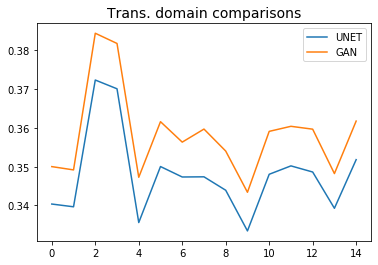

In [23]:
plt.plot(MAE_TMEAN['{}_trans'.format('UNET')], label='UNET')
plt.plot(MAE_TMEAN['{}_trans'.format('GAN')], label='GAN')
plt.legend()
plt.title('Trans. domain comparisons', fontsize=14)

Text(0.5, 1.0, 'Train. domain comparisons')

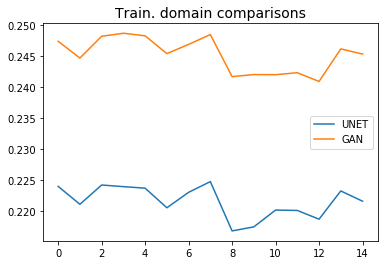

In [24]:
plt.plot(MAE_TMEAN['{}_train'.format('UNET')], label='UNET')
plt.plot(MAE_TMEAN['{}_train'.format('GAN')], label='GAN')
plt.legend()
plt.title('Train. domain comparisons', fontsize=14)

In [25]:
TMEAN_MAE_season

{'UNET_train_jja': 0.22158981688082635,
 'UNET_trans_jja': 0.34788059708104263,
 'GAN_train_jja': 0.24527661914882673,
 'GAN_trans_jja': 0.3584591956149049}

In [26]:
pick_ind = 10 # July 2019 
cut = 100

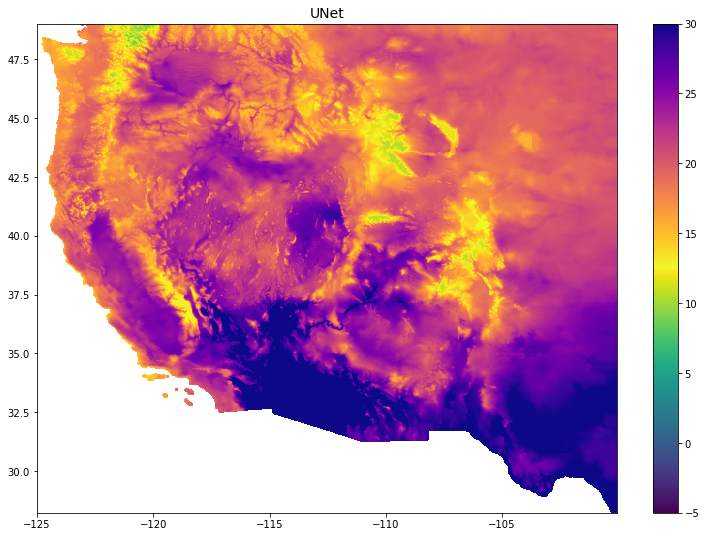

In [27]:
plt.figure(figsize=(13, 9))
plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], TMEAN['UNET'][pick_ind, cut:, :], vmin=-5, vmax=30, cmap=camp_t2)
#plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], MAE_TMEAN['UNET_grid'][cut:, ...], vmin=0, vmax=3, cmap=cmap_mae)
plt.colorbar()
plt.title('UNet', fontsize=14);

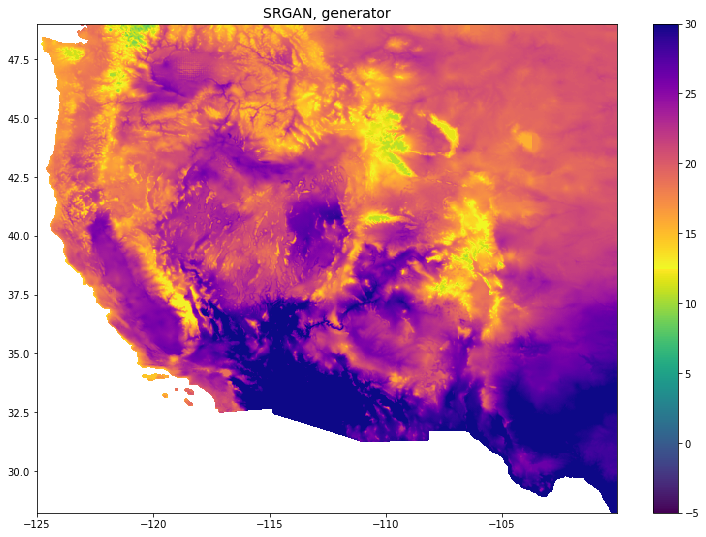

In [36]:
plt.figure(figsize=(13, 9))
plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], TMEAN['GAN'][pick_ind, cut:, :], vmin=-5, vmax=30, cmap=camp_t2)
#plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], MAE_TMEAN['GAN_grid'][cut:, ...], vmin=0, vmax=3, cmap=cmap_mae)
plt.colorbar()
plt.title('SRGAN, generator', fontsize=14);

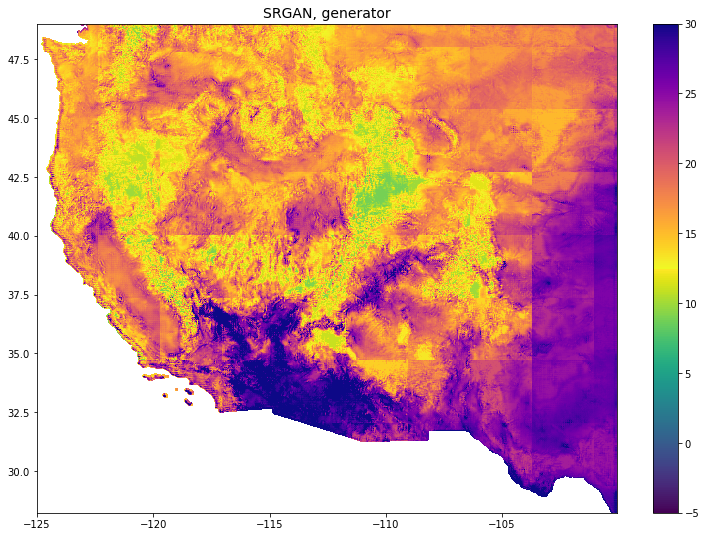

In [28]:
plt.figure(figsize=(13, 9))
plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], TMEAN['GAN'][0, cut:, :], vmin=-5, vmax=30, cmap=camp_t2)
#plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], MAE_TMEAN['GAN_grid'][cut:, ...], vmin=0, vmax=3, cmap=cmap_mae)
plt.colorbar()
plt.title('SRGAN, generator', fontsize=14);

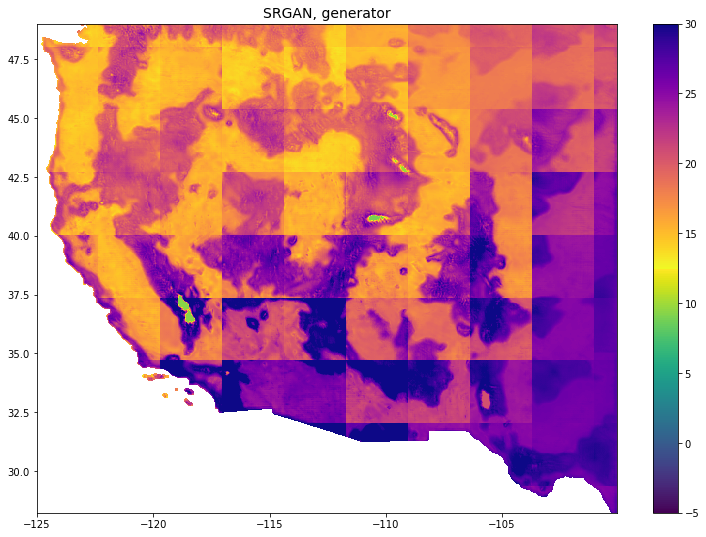

In [30]:
plt.figure(figsize=(13, 9))
plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], TMEAN['GAN'][0, cut:, :], vmin=-5, vmax=30, cmap=camp_t2)
#plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], MAE_TMEAN['GAN_grid'][cut:, ...], vmin=0, vmax=3, cmap=cmap_mae)
plt.colorbar()
plt.title('SRGAN, generator', fontsize=14);

## Summary

* GAN training with MAE loss does not work

# Verifying AE-based perceptual loss

In [20]:
TMEAN = {'UNET':RESULT_UNET, 'UNETC':RESULT_GAN}

In [21]:
TMEAN_keys = ['UNET', 'UNETC']

# for key in TMEAN_keys:
#     temp = TMEAN[key]
#     temp[:, land_mask] = np.nan
#     TMEAN[key] = temp

In [26]:
MAE_TMEAN = {}
for key in TMEAN_keys:
    # grid-point-wise MAE
    MAE_TMEAN['{}_grid'.format(key)] = du.MAE_spatial(TMEAN[key], PRISM_T)
    # domain averaged MAE
    MAE_TMEAN['{}_trans'.format(key)] = du.MAE_temporal(TMEAN[key][:, ind_trans:, :], PRISM_T[:, ind_trans:, :])
    MAE_TMEAN['{}_train'.format(key)] = du.MAE_temporal(TMEAN[key][:, :ind_trans, :], PRISM_T[:, :ind_trans, :])

/glade/u/home/ksha/WORKSPACE/utils/data_utils.py:41: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(X1-X2))


Text(0.5, 1.0, 'Trans. domain comparisons')

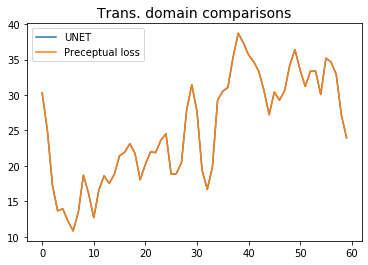

In [27]:
plt.plot(MAE_TMEAN['{}_trans'.format('UNET')], label='UNET')
plt.plot(MAE_TMEAN['{}_trans'.format('UNETC')], label='Preceptual loss')
plt.legend()
plt.title('Trans. domain comparisons', fontsize=14)

Text(0.5, 1.0, 'Train. domain comparisons')

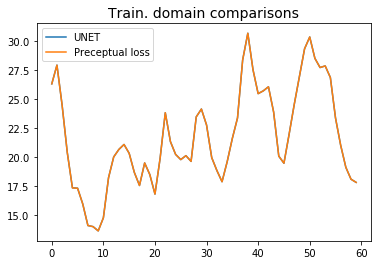

In [30]:
plt.plot(MAE_TMEAN['{}_train'.format('UNET')], label='UNET')
plt.plot(MAE_TMEAN['{}_train'.format('UNETC')], label='Preceptual loss')
plt.legend()
plt.title('Train. domain comparisons', fontsize=14)

In [20]:
pick_ind = 15 # July 2019 
cut = 100

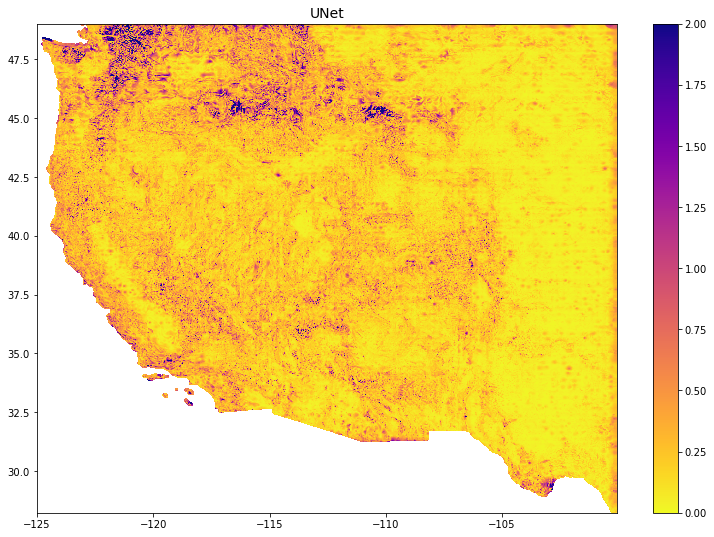

In [21]:
plt.figure(figsize=(13, 9))
#plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], TMEAN['UNET'][pick_ind, cut:, :], vmin=-5, vmax=30, cmap=camp_t2)
plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], MAE_TMEAN['UNET_grid'][cut:, ...], vmin=0, vmax=2, cmap=cmap_mae)
plt.colorbar()
plt.title('UNet', fontsize=14);

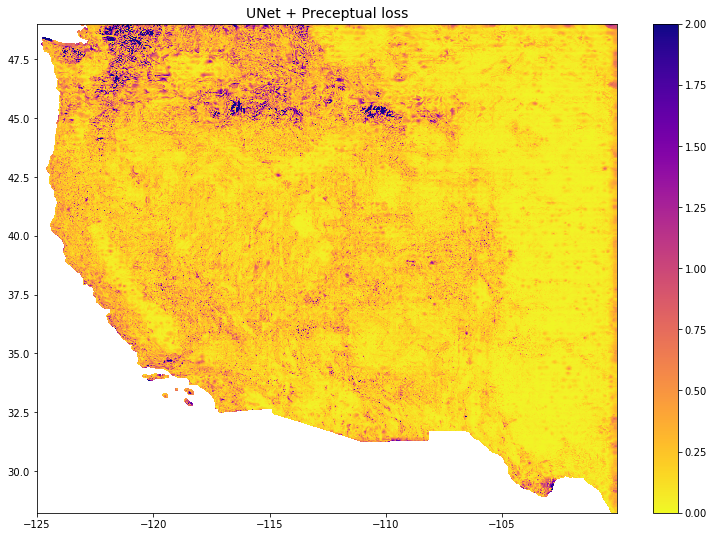

In [22]:
plt.figure(figsize=(13, 9))
#plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], TMEAN['UNETC'][pick_ind, cut:, :], vmin=-5, vmax=30, cmap=camp_t2)
plt.pcolormesh(lon_4km[cut:, ...], lat_4km[cut:, ...], MAE_TMEAN['UNETC_grid'][cut:, ...], vmin=0, vmax=2, cmap=cmap_mae)
plt.colorbar()
plt.title('UNet + Preceptual loss', fontsize=14);

In [24]:
0.01/0.2

0.049999999999999996

In [29]:
3*60*60/500

21.6

In [53]:
85+42+89+115

331